# Исследование для сервиса аренды самокатов GoFast

Нам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Нужно проанализировать данные и провеить некоторые гипотезы, которые могут помочь бизнесу вырасти. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться: 
1. без подписки - абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra - абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

## Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.

### Пользователи — users_go.csv
- user_id	- уникальный идентификатор пользователя
- name - имя пользователя
- age - возраст
- city - город
- subscription_type - тип подписки (free, ultra)

### Поездки — rides_go.csv
- user_id -	уникальный идентификатор пользователя
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date - дата совершения поездки

### Подписки — subscriptions_go.csv
- subscription_type - тип подписки
- minute_price - стоимость одной минуты поездки по данной подписке
- start_ride_price - стоимость начала поездки
- subscription_fee - стоимость ежемесячного платежа

## План работы
Всего будет 6 шагов:
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчёт выручки
6. Проверка гипотез

In [1]:
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial
import pandas as pd
import warnings
import numpy as np
from scipy.stats import binom
pd.options.mode.chained_assignment = None

## Шаг 1. Загрузка данных

In [2]:
pd.set_option('display.max_columns', None)
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subs = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
display(users.head(10))
users.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
display(rides.head(10))
rides.info()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [5]:
display(subs.head(10))
subs.info()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:** Загрузив и изучив информацию о данных, мы понимаем, что будем иметь дело с 1565 пользователями сервиса. В результате предобработки в следующем шаге, это число может измениться, но уже понятно, что данных не слишком много. Также можно заметить, что даты в датафрейме `rides` имеют тип данных `object`. Данное замечание так же исправим в следующем шаге.

## Шаг 2. Предобработка данных

Начнем предобработку с преобразования столбца `date` датафрейма `rides` в формат **datatime**.

In [6]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

Далее добавим столбец `month` в датафрейм `rides` для будущей работы с месяцами.

In [7]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

In [8]:
display(rides.head(10))
rides["date"].dt.to_period("Y").unique()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


<PeriodArray>
['2021']
Length: 1, dtype: period[A-DEC]

Мы добавили столбец, в который вынесли номер месяца поездки. А также узнали, что работаем с данными только за 2021 год.

Проверим датафреймы на наличие пропусков и дубликатов. Обработаем данные.

In [9]:
print(users.isna().sum())
print()
print(rides.isna().sum())
print()
print(subs.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


Отлично! В изучаемых данных отсутствуют пропуски.

Далее, приступим к поиску дубликатов. Чаще всего неявные дубликаты встречаются в названиях объектов(именах). Из столбцов, описывающих названия(имена), у нас `city` и `name` датафрейма `users`.

In [10]:
print(users['city'].unique())
print()
print(users['name'].sort_values().unique())

['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи']

['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсен' 'Арсений' 'Артемий'
 'Артур' 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влад' 'Влада' 'Владимир'
 'Владислав' 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий'
 'Герман' 'Глеб' 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Даниил' 'Данил'
 'Данила' 'Даниэль' 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий'
 'Ева' 'Евгений' 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей'
 'Есения' 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар'
 'Илья' 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Ки

Дубликатов в данных столбцах не выявлено. 

У каждого пользователя есть свой собственный `user_id`. Посмотрим есть ли дубликаты в этом стобце и удалим их, если они присутствуют.

In [11]:
users['user_id'].value_counts()

209     2
807     2
611     2
43      2
737     2
       ..
520     1
519     1
518     1
517     1
1534    1
Name: user_id, Length: 1534, dtype: int64

In [12]:
users = users.drop_duplicates().reset_index(drop = True)

Готово. Явные дубликаты в датафрейме `users` удалены. 

**Вывод:** На данным этапе мы выявили явные дубликаты в датафрейме `users` по айди пользователя (теперь мы знаем точное количество пользователей - **1534**). Возможно, это связано с неполадками приложения сервиса и данные дублируются.

## Шаг 3. Исследовательский анализ данных

city
Екатеринбург      204
Краснодар         193
Москва            168
Омск              183
Пятигорск         219
Ростов-на-Дону    198
Сочи              189
Тюмень            180
Name: user_id, dtype: int64

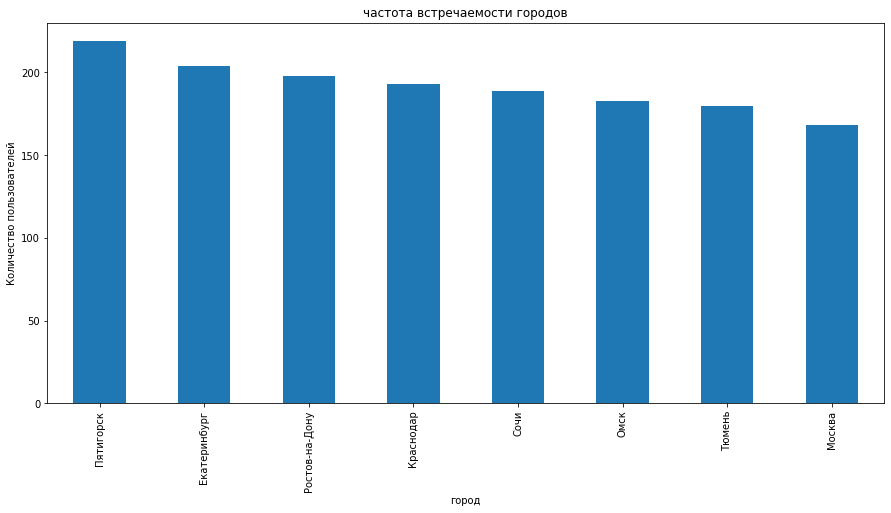

In [13]:
users.groupby("city")["user_id"].count().sort_values(ascending=False).plot(kind='bar', figsize=(15,7), title='частота встречаемости городов');
plt.xlabel('город');
plt.ylabel('Количество пользователей');
display(users.groupby("city")["user_id"].count())

По данном графике наглядно показано количество пользователей в городах. Больше всего пользователей в Пятигорске (219), меньше всего в Москве(168).

Соотношение пользователей:
Без подписки: 0.5443285528031291
С подпиской: 0.4556714471968709


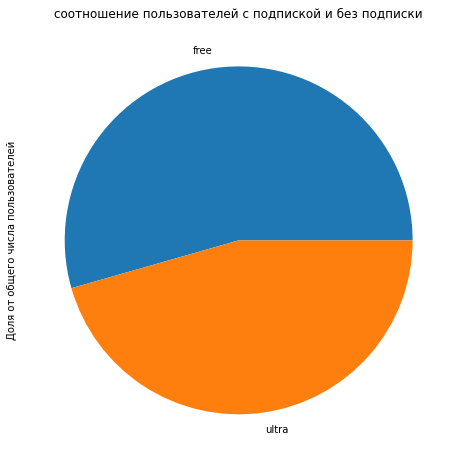

In [14]:
users.groupby("subscription_type")["user_id"].count().plot(kind='pie', figsize=(10,8), title='соотношение пользователей с подпиской и без подписки');
plt.ylabel('Доля от общего числа пользователей');

print('Соотношение пользователей:')
print('Без подписки:', len(users.loc[users['subscription_type'] == 'free']) / 1534)
print('С подпиской:', len(users.loc[users['subscription_type'] == 'ultra']) / 1534)

Пользователей с подпиской 45.6% от общего числа пользователей, без подписки 54.4%, соответственно. Пользователей без подписки больше, чем с подпиской.

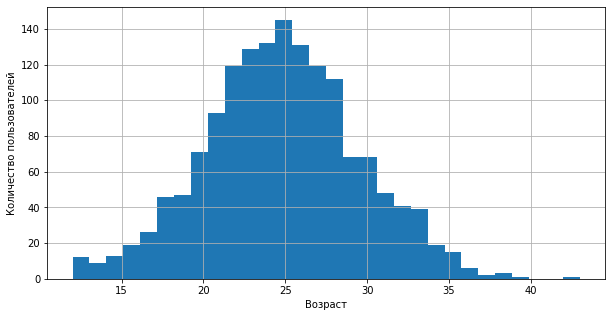

In [15]:
users['age'].sort_values().hist(bins=30, figsize=(10, 5));
plt.xlabel('Возраст');
plt.ylabel('Количество пользователей');

Основная масса пользователей в возрасте от 20 до 30 лет. Больше всего пользователей возрастом около 25 лет. 

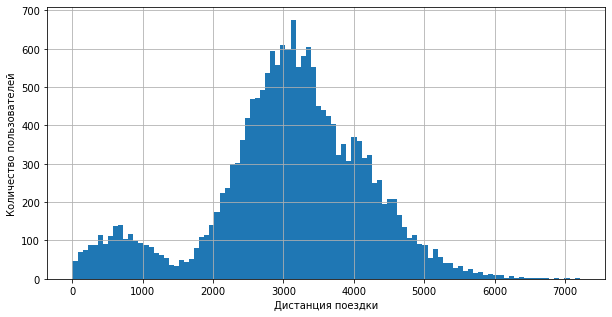

In [16]:
rides['distance'].sort_values().hist(bins=100, figsize=(10, 5));
plt.xlabel('Дистанция поездки');
plt.ylabel('Количество пользователей');

Чаще всего пользователи совершают поездки от 2000м до 4500м. Также можно наблюдать небольшой пик в области 0-1500. Можно предположить:
- некоторые пользователи были недовольны поездкой и прекратили ее не добравшись до пунка "B"
- некоторые пользователи пользуются самокатами для быстрого преодоления небольшого расстояния, когда опаздывают
- некоторые пользователи не имеют достаточно финансов для продолжительной поездки (предположительно дети, которые просто решили покататься) 
- некоторые пользователи передумали пользоваться самокатом

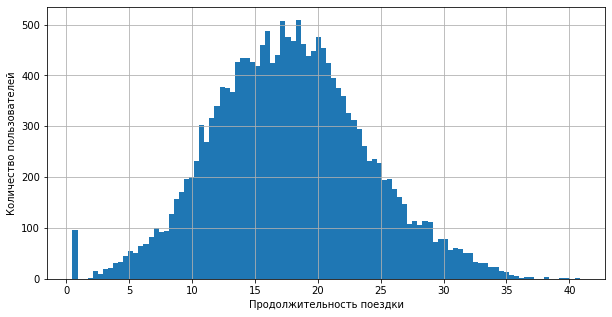

In [17]:
rides['duration'].sort_values().hist(bins=100, figsize=(10, 5));
plt.xlabel('Продолжительность поездки');
plt.ylabel('Количество пользователей');

По данной гистограмме также видим нормальное распределение с пиком около 17-18 минут. Наблюдается выброс, около 100 пользователей прекратили поездку в первую же минуту. Это может быть связано:
- с неисправностью самоката
- пользователь передумал пользоваться самокатом
- у пользователя отсутствовали финансы на дальнейшее использование самоката после бесплатного старта

**Вывод:** Можно сделать следующие выводы:
- Больше всего пользователей в Пятигорске, менее всего в Москве
- Пользователей без подписки больше, чем с подпиской
- Основная масса пользователей в возрасте от 20 до 30 лет
- Чаще всего пользователи совершают поездки от 2000м до 4500м

## Шаг 4. Объединение данных

Объединим данные о пользователях, поездках и подписках в один датафрейм. 

In [18]:
all_info = users.merge(
rides,
on='user_id', 
)

all_info = all_info.merge(
subs,
on='subscription_type',
)

all_info

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


Создадим из полученной таблицы еще 2 датафрейма, в которых разделим пользователей с подпиской и без нее.

In [19]:
ultra_subs = all_info.loc[all_info['subscription_type'] == 'ultra']
free_subs = all_info.loc[all_info['subscription_type'] == 'free']
ultra_subs['duration'] = np.ceil(ultra_subs['duration'])
free_subs['duration'] = np.ceil(free_subs['duration'])

display(ultra_subs.head(10))
display(free_subs.head(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,17.0,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,15.0,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,24.0,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,16.0,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,16.0,2021-11-22,11,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,15.0,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,17.0,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,21.0,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,10.0,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,18.0,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,23.0,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,19.0,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,16.0,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,17.0,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,12.0,2021-06-23,6,8,50,0


Изучим информацию о расстоянии и времени поездок для каждой группы пользователей.

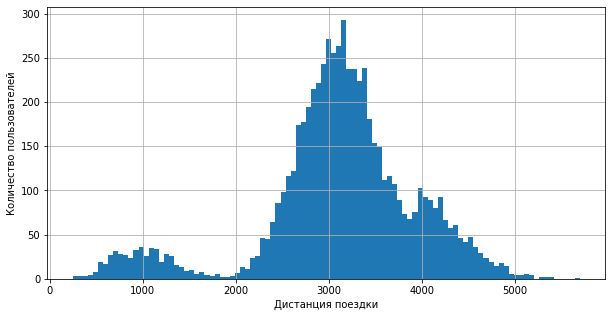

In [20]:
ultra_subs['distance'].sort_values().hist(bins=100, figsize=(10, 5));
plt.xlabel('Дистанция поездки');
plt.ylabel('Количество пользователей');

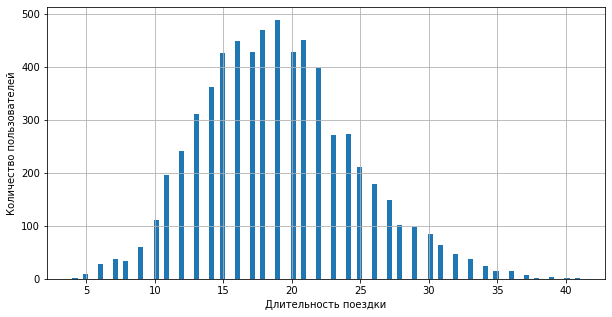

In [21]:
ultra_subs['duration'].sort_values().hist(bins=100, figsize=(10, 5));
plt.xlabel('Длительность поездки');
plt.ylabel('Количество пользователей');

Дистанция поездок у пользователей с подпиской в основном варьируется между значениями 2500-4000 метров. Время же поездок для этих пользователей от 10 до 25 минут. неплохие показатели для GoFast!

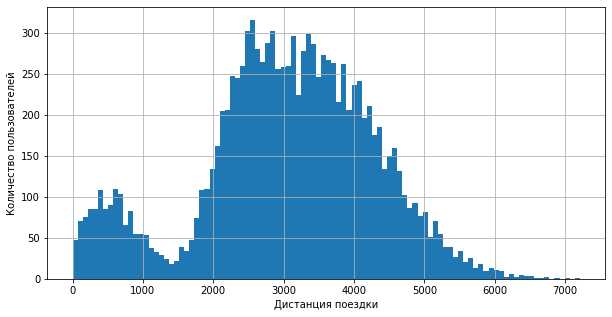

In [22]:
free_subs['distance'].sort_values().hist(bins=100, figsize=(10, 5));
plt.xlabel('Дистанция поездки');
plt.ylabel('Количество пользователей');

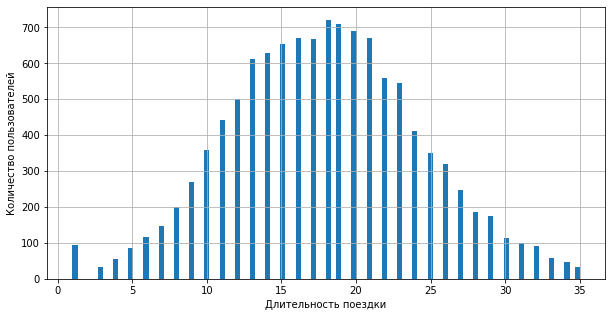

In [23]:
free_subs['duration'].sort_values().hist(bins=100, figsize=(10, 5));
plt.xlabel('Длительность поездки');
plt.ylabel('Количество пользователей');

Для пользователей без подписки дистанция поездок варьируется между 2000-4.500м. Длительность поездок данных пользователей от 10 до 25 минут. По этим гистограммам заметно, что многие пользователи без подписки намного чаще проедолевают расстояние до 1000м и виден выброс в длительности поездки в 1 минуту. Можно предположить, что это новые пользователи, которые не ознакомились со стоимостью поездки и после первой же минуты при отсутствии финансов поездка завершалась.   

Также можно сделать вывод, что пользователи с подпиской часто пользуются самокатами чтобы добраться до определенной точки "B", соответственно знают зачем начинают поездку. Пользователи же без подписки, скорее всего гуляют, либо пользуются самокатом в случае необходимости, поэтому расстояние и длительсность поездок варьируется в большом диапазоне.

## Шаг 5. Подсчёт выручки

**Узнаем помесячную выручку, которую принес каждый пользователь.**

Для этого сгруппируем данные датафрейма `all_info` по пользователям и месяцу их поездки. Далее добавим функции к столбцам `date`, `distance` и `duration`. Для удобства переименуем получившийся столбец `date` в `rides_total` (указанный месяц у нас в колонке `month`. Добавим столбцы, необходимые для подсчета выручки и посчитаем ее. Добавим столбец с получившимися результатами. 

In [24]:
all_info['duration'] = np.ceil(all_info['duration'])

grouped = all_info.groupby(['user_id','month'], as_index=False).agg({'date':['count'], 'distance':['sum'], 'duration':['sum']})
grouped['minute_price'] = all_info['minute_price']
grouped['start_ride_price'] = all_info['start_ride_price']
grouped['subscription_fee'] = all_info['subscription_fee']
grouped.rename(columns = {'date':'rides_total'}, inplace = True)
grouped['income'] = (grouped['start_ride_price'] * grouped['rides_total']['count']) + (grouped['minute_price'] * grouped['duration']['sum']) + grouped['subscription_fee']
grouped

,user_id,month,rides_total,distance,duration,minute_price,start_ride_price,subscription_fee,income
,,,count,sum,sum,,,,
0,1,1,2,7027.511294,42.0,6,0,199,451.0
1,1,4,1,754.159807,7.0,6,0,199,241.0
2,1,8,2,6723.470560,46.0,6,0,199,475.0
3,1,10,2,5809.911100,32.0,6,0,199,391.0
4,1,11,3,7003.499363,56.0,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,8,50,0,308.0
11327,1534,8,2,7622.453034,48.0,8,50,0,484.0
11328,1534,9,1,4928.173852,23.0,8,50,0,234.0


In [25]:
grouped.groupby('subscription_fee')['income'].mean()

subscription_fee
0      328.345270
199    368.676308
Name: income, dtype: float64

**Вывод**: Помесячная выручка с каждого пользователя посчитана, в датафрейм добавлен соответствующий столбец. Средняя выручка в месяц:
- для пользователей с подпиской: 368.6
- для пользователей без подписки: 328.3

## Шаг 6. Проверка гипотез

Приступим к проверке гипотез, результаты которой помогут продакт-менеджерам сервиса улучшить свои показатели.

### Первая гипотеза 
**Нулевая гипотеза**:Пользователи с подпиской тратят столько же времени на поездки, сколько пользователи без подписки.
**Альтернативная гипотеза**: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [26]:
alpha=0.05

results = st.ttest_ind(ultra_subs['duration'], free_subs['duration'], equal_var=False, alternative = 'greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.1814679253701353e-36
Отвергаем нулевую гипотезу


**Вывод**: Отвергаем нулевую гипотезу. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Соответственно, они могут быть "выгоднее" для компании!

### Вторая гипотеза: 
**Нулевая гипотеза:** Расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. **Альтернативная гипотеза**: В основном расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает оптимальное в 3130 метров.

In [27]:
optimal_value = 3130
alpha=0.1

results = st.ttest_1samp(ultra_subs['distance'], optimal_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод:** Не получилось отвергнуть нулевую гипотезу. Расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров.

### Третья гипотеза:
**Нулевая гипотеза**: Помесячная выручка пользователей с подпиской и без подписки равны. **Альтернативная гипотеза**: Помесячная выручка от пользователей c с подпиской выше, чем выручка от пользователей без подписки.

In [28]:
ultra_subs['income'] = grouped['income']
free_subs['income'] = grouped['income']
ultra_subs_income = ultra_subs.pivot_table(index = 'user_id', values='income')
free_subs_income = free_subs.pivot_table(index = 'user_id', values='income')

In [29]:
alpha = 0.05

results = st.ttest_ind(ultra_subs_income, free_subs_income, equal_var=False, alternative='greater')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: [9.30995279e-36]
Отвергаем нулевую гипотезу


**Вывод:** Отвергаем нулевую гипотезу. Помесячная выручка от пользователей c с подпиской выше, чем выручка от пользователей без подписки.

## Общий вывод

В результате проведенного нами исследования можно подытожить:
- Больше всего пользователей в Пятигорске, менее всего в Москве
- Пользователей без подписки больше, чем с подпиской
- Основная масса пользователей в возрасте от 20 до 30 лет
- Чаще всего пользователи совершают поездки от 2000м до 4500м

    Можно сделать вывод, что пользователи с подпиской часто пользуются самокатами чтобы добраться до определенной точки "B", соответственно знают зачем начинают поездку. Пользователи же без подписки, скорее всего гуляют, либо пользуются самокатом в случае необходимости, поэтому расстояние и длительсность поездок варьируется в большом диапазоне. Но в целом, профили пользователей обеих подписок похожи.
    
Средняя выручка в месяц по пользователям:
- для пользователей с подпиской: 368.6
- для пользователей без подписки: 328.3

Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Соответственно, они могут быть "выгоднее" для компании.
    
В основном среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, равно 3130 метров. Это не превосходит расстояние, оптимальное с точки зрения износа самоката.
    
Пользователи с подпиской ежемесячно приносят больше выручки компании, чем пользователи без подписки. При чем стабильно! По результатам каждого месяца выручка с пользователей-подписчиков выше, чем у пользователей без подписки.

**Исходя из вышенаписанного, пользователи с подпиской приносят больше прибыли компании. Большее количество промоакций, направленных на приобретение пользователем подписки, позитивно скажутся на общей выручке сервиса**. 